<a id=top-page></a>
# `pykitPIV` demo: Learn to find sources and sinks in a 2D PIV experiment using reinforcement learning

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>

</ol>
<p></p>
</div>
<br>

***

In [28]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

In [2]:
interrogation_window_size = (40,40)

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [3]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [4]:
flowfield_spec = FlowFieldSpecs(size=(200, 300),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [5]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [6]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


### Prepare the CNN-based inference model for PIV images:

In [7]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [8]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [9]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [10]:
cues_obj = Cues(sample_every_n=5, 
                normalize_displacement_vectors=True)
cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium` environment:

In [11]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=5,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             random_seed=None)

In [12]:
camera_position, cues = env.reset()

In [13]:
cues.shape

(1, 128)

***

## Create and train the RL agent

In [30]:
n_episodes = 50
n_iterations = 5

epsilon_start = 0.8
discount_factor = 0.3

batch_size = 128
memory_size = 200
n_epochs = 1

initial_learning_rate = 0.001
alpha_lr = 0.01
kernel_initializer = tf.keras.initializers.Ones
kernel_initializer = tf.keras.initializers.RandomUniform

n_decay_steps_epsilon = n_episodes
n_decay_steps_learning_rate = n_episodes

Define the exploration probability decay:

In [15]:
def epsilon_exp_decay(epsilon_start, iter_count, n=1000):
    return epsilon_start/np.exp(iter_count/(n))

In [16]:
exploration_probabilities = []

for i in range(0,n_episodes):

    exploration_probabilities.append(epsilon_exp_decay(epsilon_start, i, n=n_episodes))

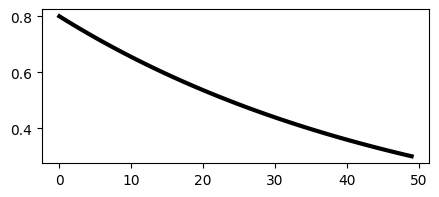

In [17]:
plt.figure(figsize=(5,2))
plt.plot(exploration_probabilities, c='k', lw=3);

Define the cosine learning rate decay:

In [18]:
def decayed_learning_rate(step, initial_learning_rate, alpha, decay_steps):
    
    step = np.min([step, decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    
    return initial_learning_rate * decayed

In [19]:
decayed_learning_rates = []

for i in range(0,n_episodes):

    decayed_learning_rates.append(decayed_learning_rate(i, 
                                                        initial_learning_rate=initial_learning_rate, 
                                                        alpha=alpha_lr, 
                                                        decay_steps=n_decay_steps))

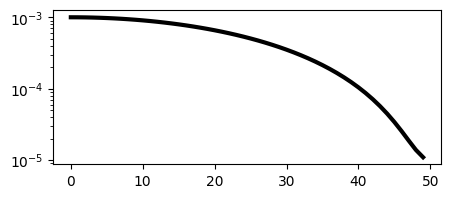

In [20]:
plt.figure(figsize=(5,2))
plt.semilogy(decayed_learning_rates, c='k', lw=3);

Define the Q-network:

In [21]:
class QNetwork(tf.keras.Model):
    
    def __init__(self, n_actions, kernel_initializer):
        
        super(QNetwork, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(8, activation='tanh', kernel_initializer=kernel_initializer)
        self.dense3 = tf.keras.layers.Dense(6, activation='tanh', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='linear', kernel_initializer=kernel_initializer)

    def call(self, state):
        
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return self.output_layer(x)

Initialize the camera agent:

In [22]:
ca = CameraAgent(env=env,
                 target_q_network=QNetwork(env.n_actions, kernel_initializer),
                 online_q_network=QNetwork(env.n_actions, kernel_initializer),
                 memory_size=memory_size,
                 batch_size=batch_size,
                 n_epochs=n_epochs,
                 learning_rate=initial_learning_rate,
                 optimizer='RMSprop',
                 discount_factor=discount_factor)

The uploaded environment has 5 actions.


We are going to use the reward based on divergence:

In [23]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting vortex structures:

In [24]:
def reward_transformation(div):  
    return np.max(np.abs(div))*10

In [25]:
# saved_camera_trajectories_H = np.zeros((n_iterations, n_episodes))
# saved_camera_trajectories_W = np.zeros((n_iterations, n_episodes))

In [26]:
batch_q_values_collected = np.zeros((1, env.n_actions))

In [29]:
total_tic = time.perf_counter()

print()
print('- '*50)
print('Starting training the RL agent...\n')

tic = time.perf_counter()

iter_count = 0
total_rewards = []
current_lr = cp.deepcopy(initial_learning_rate)

batch_q_values_collected = np.zeros((1, env.n_actions))

log_every = 1

for episode in range(0, n_episodes):

    camera_position, cues = ca.env.reset(regenerate_flowfield=True)
    total_reward = 0

    # Before we start training the Q-network, only exploration is allowed:
    if len(ca.memory.buffer) >= batch_size:

        # Exploration probability decreases with training time:
        epsilon = epsilon_exp_decay(epsilon_start,
                                    iter_count,
                                    n=n_decay_steps_epsilon)

        # Decay the learning rate:
        current_lr = decayed_learning_rate(iter_count,
                                           initial_learning_rate,
                                           alpha_lr,
                                           n=n_decay_steps_learning_rate)

        iter_count += 1  # Only counts episodes that had Q-network trainings in them

    else:

        epsilon = 1.0

    if (episode) % log_every == 0:

        print(f'Episode: {episode + 1}')
        print(f'Epsilon: {epsilon:0.3f}')
        print('Learning rate: ' + str(current_lr))

    for i in range(0,n_iterations):

        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              verbose=False)

        ca.remember(cues,
                    action,
                    reward,
                    next_cues)

        cues = next_cues
        total_reward += reward

        # Train the Q-network after each step, (but hold off with training until batch_size of samples is collected):
        if len(ca.memory.buffer) >= batch_size:

            ca.train(current_lr)

    batch_q_values = ca.online_q_network(cues).numpy()
    batch_q_values_collected = np.vstack((batch_q_values_collected, batch_q_values))

    # Synchronize the Q-networks only at the end of each episode:
    if len(ca.memory.buffer) >= batch_size:
        ca.update_target_network()
    
    if (episode) % log_every == 0:

        toc = time.perf_counter()

        print(f"Total Reward: {total_reward:0.1f}")
        print(f'This episode took: {(toc - tic):0.1f} sec.')
        print('- '*15)
        print()

        tic = time.perf_counter()

    total_rewards.append(total_reward)

batch_q_values_collected = batch_q_values_collected[1::,:]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Starting training the RL agent...

Episode: 1
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 1.1
This episode took: 0.2 sec.
- - - - - - - - - - - - - - - 

Episode: 2
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 0.8
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 3
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 0.6
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 4
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 1.1
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 5
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 1.2
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 6
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 0.7
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 7
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 1.1
This episode took: 0.1 sec.
- - - - - - - - - - 

NameError: name 'n_decay_steps_epsilon' is not defined

In [ ]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()
plt.figure(figsize=(20,4))
plt.semilogy(MSE_losses_collected)
plt.xlabel('Epoch #', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(total_rewards, 'ko--')

In [ ]:
plt.figure(figsize=(10,4))
for i in range(0,5):
    plt.plot(batch_q_values_collected[:,i], label='Action ' + str(i+1))
plt.xlabel('Episode #', fontsize=20)
plt.ylabel('Q-value', fontsize=20)
plt.legend(frameon=False)

Visualize trajectories taken by the agent in each episode:

In [ ]:
# episode = -1
# plt.plot(saved_camera_trajectories_W[:,episode], saved_camera_trajectories_H[:,episode])

### Visualize the learned policy in the training environment

Create sparse samples of camera position on a uniform grid:

In [ ]:
(_, _, H, W) = ca.env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = ca.env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 2 == 0]
idx_W = [i for i in range(0, W_adm) if i % 2 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = ca.env.reset(imposed_camera_position=camera_position)
        q_values = ca.target_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

In [ ]:
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(ca.env.action_to_verbose_direction.values()))
# plt.xticks([])
# plt.yticks([])
plt.savefig('policy.png', dpi=300, bbox_inches='tight')

In [ ]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

***

## Test the trained agent on a new environment

In [ ]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

In [ ]:
flowfield_spec = FlowFieldSpecs(size=(200, 300),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

In [ ]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

In [ ]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

In [ ]:
test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=10,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [ ]:
camera_position, cues = test_env.reset()

In [ ]:
plt = test_env.render(camera_position,
                     c='white',
                     s=20,
                     lw=1,
                     normalize_cbars=True,
                     cmap=cmc.roma,
                     add_streamplot=True,
                     streamplot_density=3,
                     streamplot_color='k',
                     streamplot_linewidth=0.3,
                     figsize=(15,6), 
                     filename=None)

### Visualize the learned policy in the test environment

Create sparse samples of camera position on a uniform grid:

In [ ]:
(_, _, H, W) = test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 10 == 0]
idx_W = [i for i in range(0, W_adm) if i % 10 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
learned_policy = np.ones((H,W)) * np.NaN

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = test_env.reset(imposed_camera_position=camera_position)
        q_values = ca.target_q_network.predict(cues, verbose=0)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

In [ ]:
from matplotlib.colors import ListedColormap
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(test_env.action_to_verbose_direction.values()))
plt.xticks([])
plt.yticks([])

### Visualize one sample trajectory in the test environment

We are going to take a number of steps in the environment:

In [ ]:
n_steps = 100

In [ ]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [ ]:
camera_position, cues = test_env.reset()

In [ ]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.target_q_network.predict(cues, verbose=0)

    action = np.argmax(q_values)

    if i%10 == 0: print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  verbose=False)

In [ ]:
plot_trajectory(test_env.flowfield.velocity_field,
                saved_camera_trajectories,
                interrogation_window_size=interrogation_window_size,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=None);

***

## Upload the Q-network trained on the cluster

In [ ]:
target_q_network = QNetwork(n_actions=5, kernel_initializer = tf.keras.initializers.RandomUniform)
_ = target_q_network(tf.ones((1, 32)))

In [ ]:
target_q_network.load_weights("../scripts/QNetwork.keras")

In [ ]:
qntarget_q_networket2.get_weights()

***